In [0]:
import pandas as pd
import numpy as np
import cv2

In [0]:
#add google drive with dataframe
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#data on my drive 
!ls "/content/drive/My Drive"

'Colab Notebooks'   Книги   Спирин.gdoc


In [0]:
#copy my dataframe in local drive
!cp /content/drive/'My Drive'/'Colab Notebooks'/leaf_diseases.zip .

In [0]:
!ls

drive  leaf_diseases.zip  sample_data


In [0]:
#unpacking the archive
!unzip leaf_diseases.zip

Archive:  leaf_diseases.zip
   creating: plant-pathology-2020-fgvc7/
  inflating: plant-pathology-2020-fgvc7/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/plant-pathology-2020-fgvc7/
  inflating: __MACOSX/plant-pathology-2020-fgvc7/._.DS_Store  
   creating: plant-pathology-2020-fgvc7/images/
  inflating: plant-pathology-2020-fgvc7/images/Train_1088.jpg  
   creating: __MACOSX/plant-pathology-2020-fgvc7/images/
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1088.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_364.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_364.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_1705.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1705.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_1063.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1063.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_402.jpg  
  inflating: __MACOSX

In [0]:
#delete extra files
!rm -rf /content/__MACOSX

In [0]:
!ls

drive  leaf_diseases.zip  plant-pathology-2020-fgvc7  sample_data


In [0]:
#check our images
!ls plant-pathology-2020-fgvc7/images

Train_0.jpg	Train_1329.jpg	Train_1658.jpg	Train_347.jpg  Train_676.jpg
Train_1000.jpg	Train_132.jpg	Train_1659.jpg	Train_348.jpg  Train_677.jpg
Train_1001.jpg	Train_1330.jpg	Train_165.jpg	Train_349.jpg  Train_678.jpg
Train_1002.jpg	Train_1331.jpg	Train_1660.jpg	Train_34.jpg   Train_679.jpg
Train_1003.jpg	Train_1332.jpg	Train_1661.jpg	Train_350.jpg  Train_67.jpg
Train_1004.jpg	Train_1333.jpg	Train_1662.jpg	Train_351.jpg  Train_680.jpg
Train_1005.jpg	Train_1334.jpg	Train_1663.jpg	Train_352.jpg  Train_681.jpg
Train_1006.jpg	Train_1335.jpg	Train_1664.jpg	Train_353.jpg  Train_682.jpg
Train_1007.jpg	Train_1336.jpg	Train_1665.jpg	Train_354.jpg  Train_683.jpg
Train_1008.jpg	Train_1337.jpg	Train_1666.jpg	Train_355.jpg  Train_684.jpg
Train_1009.jpg	Train_1338.jpg	Train_1667.jpg	Train_356.jpg  Train_685.jpg
Train_100.jpg	Train_1339.jpg	Train_1668.jpg	Train_357.jpg  Train_686.jpg
Train_1010.jpg	Train_133.jpg	Train_1669.jpg	Train_358.jpg  Train_687.jpg
Train_1011.jpg	Train_1340.jpg	Train_166.jpg	Tr

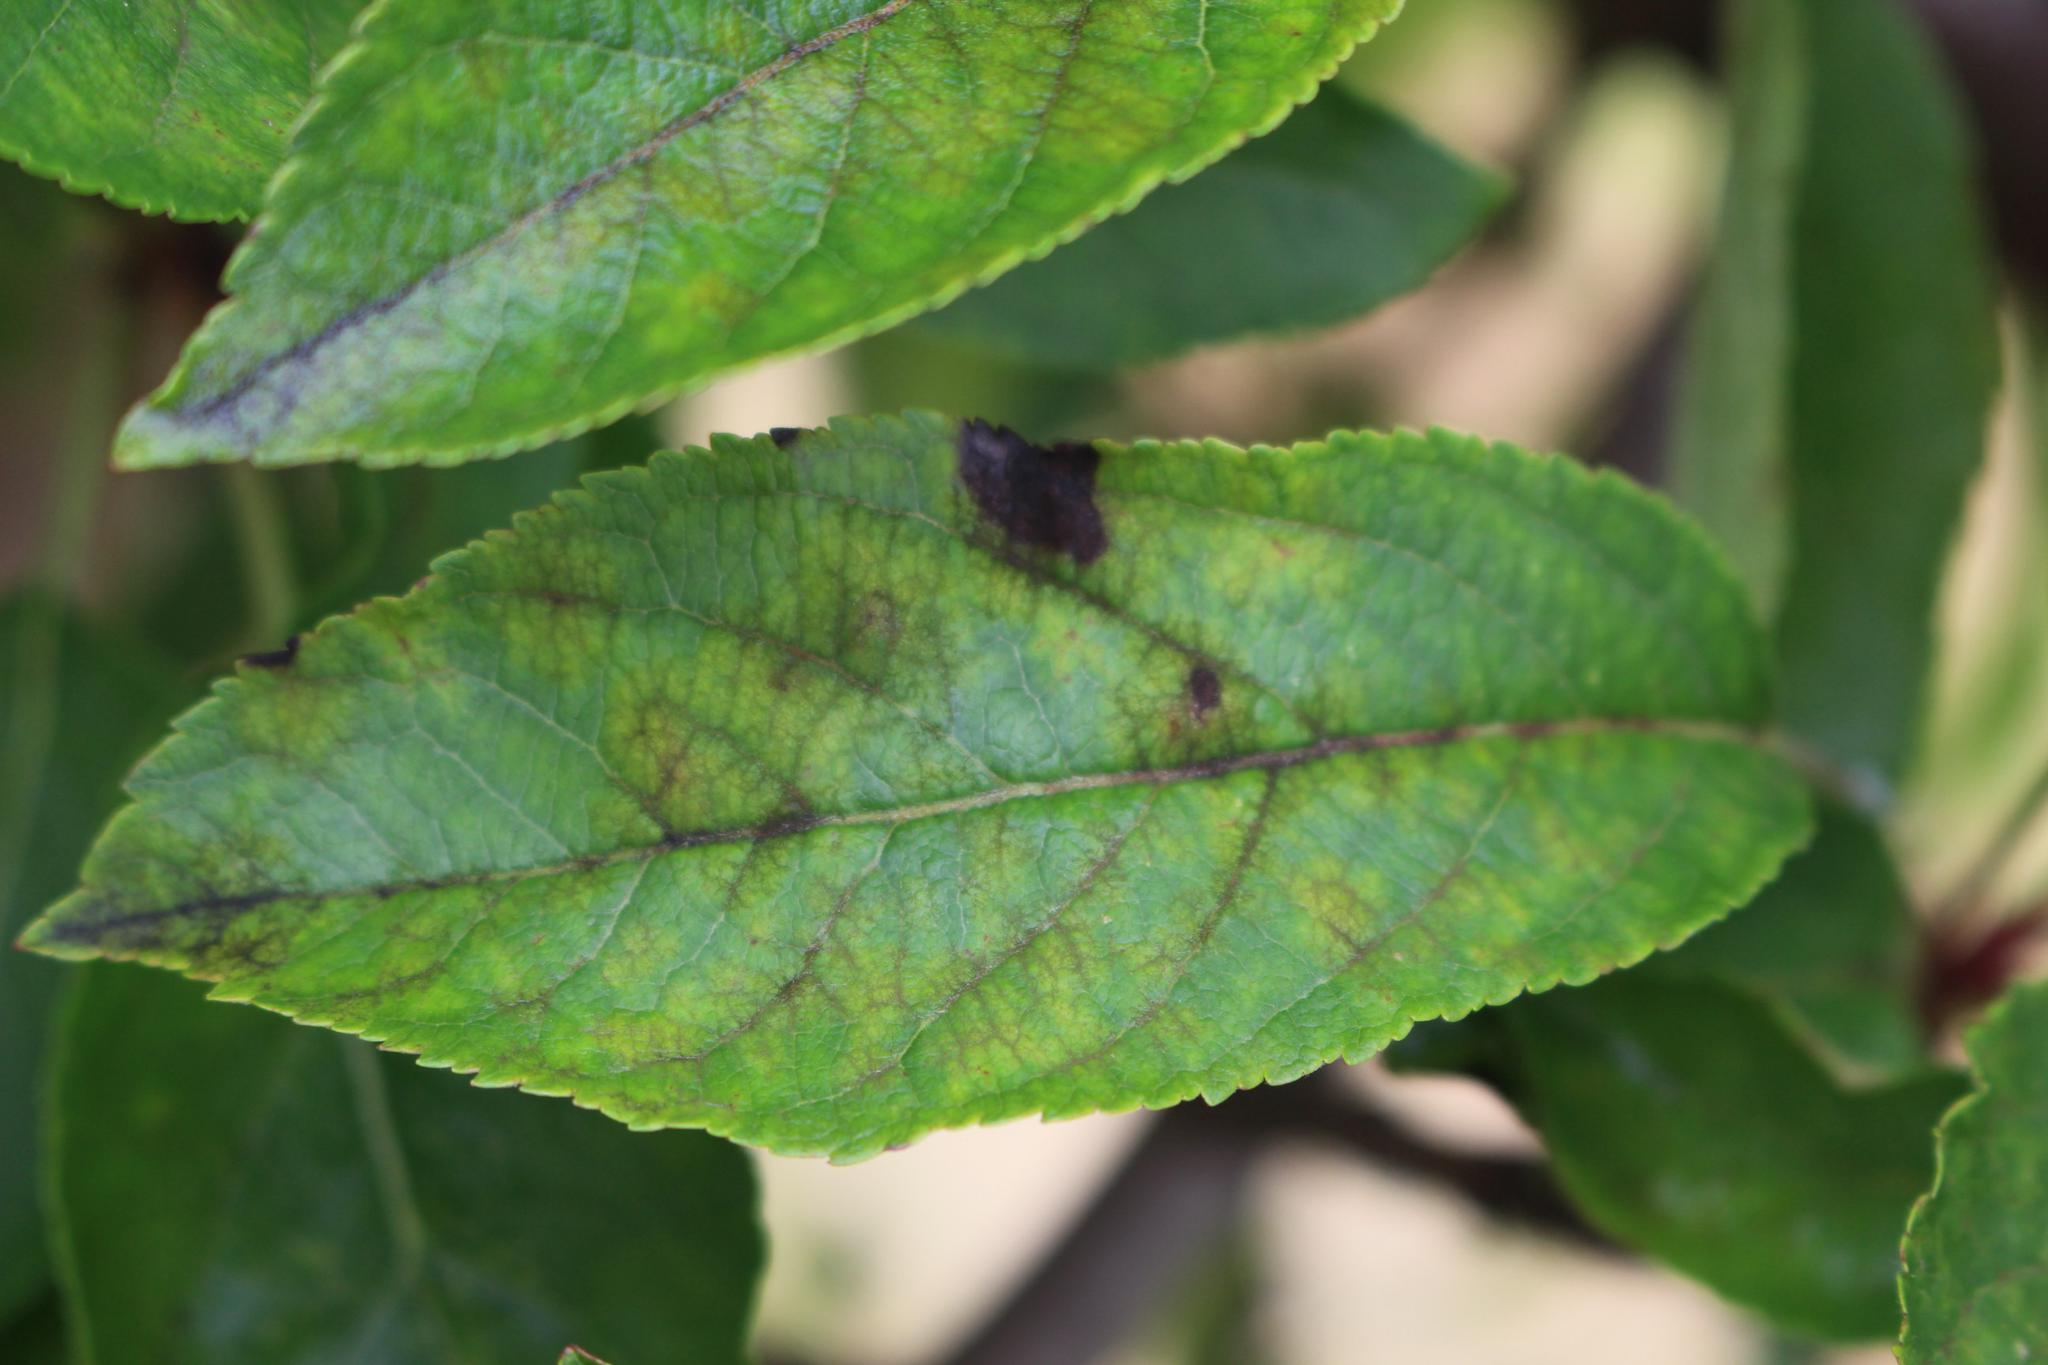

In [0]:
#show image
from IPython.display import Image
Image('plant-pathology-2020-fgvc7/images/Train_1650.jpg')

In [0]:
#connect our dataframe
df = pd.read_csv('/content/plant-pathology-2020-fgvc7/train.csv')

In [0]:
df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


### Prepare our data for train





In [0]:
target = df[['healthy', 'multiple_diseases', 'rust', 'scab']]

In [0]:
#resize
IMAGE_PATH = "/content/plant-pathology-2020-fgvc7/images/"
def resize_image(image):
  width = 100
  height = 100
  dim = (width, height)
  return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [0]:
def load_images(df):
  images = []
  for i in df['image_id']:
    image = cv2.imread(IMAGE_PATH + i + ".jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(resize_image(image))
  return images

In [0]:
train_images = load_images(df)
train_images = np.array(train_images) 

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), test_size=0.1, random_state=100) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1638, 100, 100, 3), (183, 100, 100, 3), (1638, 4), (183, 4))

###Train without dropout

In [40]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dense
from keras import layers
from keras import models

model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 128)      

In [41]:
from keras.preprocessing.image import ImageDataGenerator

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model.fit(x_train, y_train, batch_size=128,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 1638 samples, validate on 183 samples
Epoch 1/25
1638/1638 [==============================] - 37s 23ms/step - loss: 3.0985 - acc: 0.4310 - val_loss: 4.7176 - val_acc: 0.3279
Epoch 2/25
1638/1638 [==============================] - 36s 22ms/step - loss: 1.1101 - acc: 0.5763 - val_loss: 3.9359 - val_acc: 0.3552
Epoch 3/25
1638/1638 [==============================] - 36s 22ms/step - loss: 0.7651 - acc: 0.7045 - val_loss: 2.0210 - val_acc: 0.2404
Epoch 4/25
1638/1638 [==============================] - 36s 22ms/step - loss: 0.5088 - acc: 0.8327 - val_loss: 2.1236 - val_acc: 0.2404
Epoch 5/25
1638/1638 [==============================] - 37s 22ms/step - loss: 0.3184 - acc: 0.9243 - val_loss: 1.7519 - val_acc: 0.2350
Epoch 6/25
1638/1638 [==============================] - 37s 22ms/step - loss: 0.2037 - acc: 0.9591 - val_loss: 1.4128 - val_acc: 0.2404
Epoch 7/25
1638/1638 [==============================] - 37s 23ms/step - loss: 0.1109 - acc: 0.9847 - val_loss: 1.3482 - val_acc: 0.3497
E

In [42]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6720563007182763
Test accuracy: 0.7923497557640076


### Train with dropout

In [45]:
from keras.layers import Dropout

model2 = models.Sequential() 
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))
model2.add(layers.Flatten()) 
model2.add(layers.Dense(512, activation='relu')) 
model2.add(Dense(4, activation='softmax'))
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 23, 64)       

In [46]:
from keras.preprocessing.image import ImageDataGenerator

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model2.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_test, y_test))

Train on 1638 samples, validate on 183 samples
Epoch 1/25
1638/1638 [==============================] - 40s 25ms/step - loss: 3.1990 - acc: 0.3748 - val_loss: 13.5070 - val_acc: 0.3552
Epoch 2/25
1638/1638 [==============================] - 39s 24ms/step - loss: 1.3974 - acc: 0.4744 - val_loss: 8.0755 - val_acc: 0.3552
Epoch 3/25
1638/1638 [==============================] - 39s 24ms/step - loss: 1.0761 - acc: 0.5574 - val_loss: 2.2949 - val_acc: 0.2404
Epoch 4/25
1638/1638 [==============================] - 39s 24ms/step - loss: 0.9279 - acc: 0.6264 - val_loss: 1.8839 - val_acc: 0.3443
Epoch 5/25
1638/1638 [==============================] - 39s 24ms/step - loss: 0.7797 - acc: 0.6990 - val_loss: 1.4741 - val_acc: 0.2295
Epoch 6/25
1638/1638 [==============================] - 39s 24ms/step - loss: 0.6817 - acc: 0.7344 - val_loss: 1.3699 - val_acc: 0.2896
Epoch 7/25
1638/1638 [==============================] - 39s 24ms/step - loss: 0.5803 - acc: 0.7778 - val_loss: 1.3554 - val_acc: 0.3005


In [47]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3905025720596313
Test accuracy: 0.6174863576889038
